### Check the landmasking in the boundary conditions files

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean

#### Functions

#### Read files

In [36]:
# running with bdy_ind = -1, for domain of size 453, so should be index 151 I think.
terra = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/'
domain_cfg = xr.open_dataset(f'{terra}bathymetry/domain_cfg-20240123-filledlakes.nc')
mesh_mask  = xr.open_dataset(f'{terra}bathymetry/mesh_mask-20240123-filledlakes.nc').isel(time_counter=0)
bdy_cond     = xr.open_dataset(f'{terra}boundary-conditions/B-SOSE/SOSE-SALT-boundary-conditions-20240125_m01.nc').isel(time_counter=0, y=0)
bdy_cond_new = xr.open_dataset(f'{terra}boundary-conditions/SOSE-SALT-boundary-conditions-20240219_m01.nc').isel(time_counter=0, y=0)

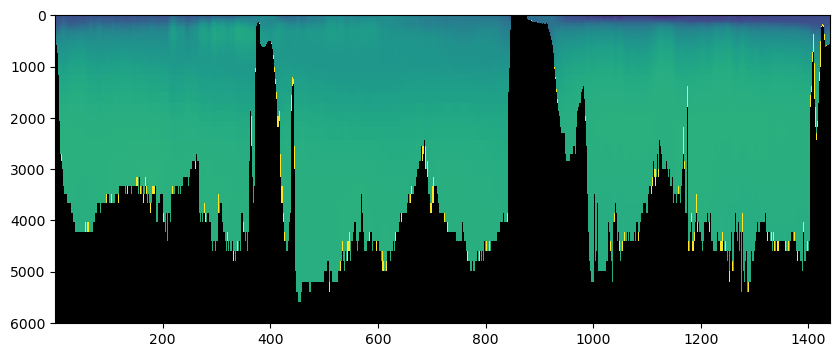

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.invert_yaxis()

ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, bdy_cond.SALT, vmin=33, vmax=36)
plot_land = np.ma.masked_where(mesh_mask.tmask.isel(y=451)==1, mesh_mask.tmask.isel(y=451))
ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, plot_land, cmap=cmocean.cm.gray)

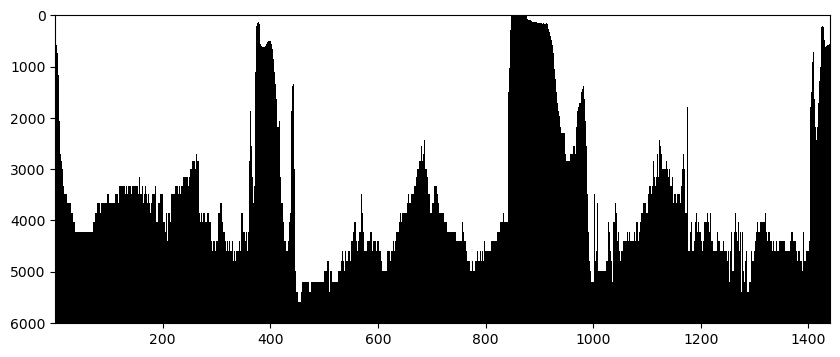

In [70]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.invert_yaxis()
# ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, bdy_cond_new.SALT, vmin=33, vmax=36)
plot_land = np.ma.masked_where(mesh_mask.tmask.isel(y=451)==1, mesh_mask.tmask.isel(y=451))
ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, plot_land, cmap=cmocean.cm.gray)

In [41]:
print(np.argwhere((mesh_mask.tmask.isel(y=452).values==1)*(bdy_cond.SALT.values==9999)))
print(np.argwhere((mesh_mask.tmask.isel(y=451).values==1)*(bdy_cond_new.SALT.values==9999)))

[]
[]


In [43]:
bdy_cond_new.SALT.isel(x=slice(874,878))

<xarray.DataArray 'SALT' (deptht: 121, x: 4)>
array([[ 0.      , 34.057237, 34.057237, 34.03704 ],
       [ 0.      , 34.057237, 34.057237, 34.03704 ],
       [ 0.      , 34.057237, 34.057237, 34.03704 ],
       ...,
       [ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ]])
Coordinates:
  * x        (x) float32 -68.5 -68.25 -68.0 -67.75
    y        float32 -50.22
Dimensions without coordinates: deptht

Let's have a look at the output after the first time steps:

In [100]:
ds = xr.open_dataset(f'{terra}output/new-setup-testing/BDY_1/eANT025.L121_1ts_19790101_19790102_grid_T_19790101000000-19790101072959.nc').isel(time_counter=15)

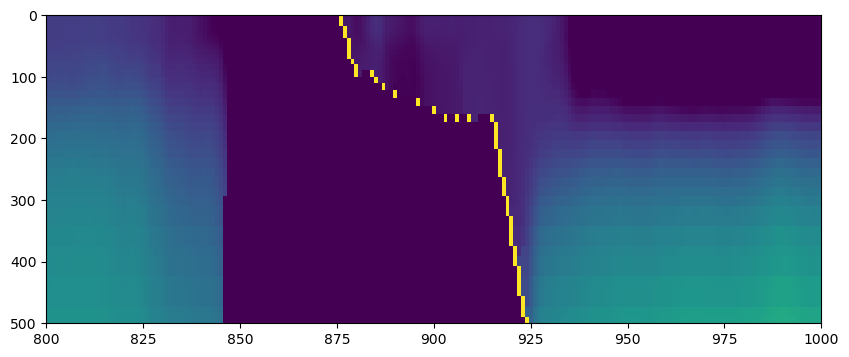

In [101]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.invert_yaxis()
ax.set_ylim(500,0)
ax.set_xlim(800,1000)
ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, ds.so.isel(y_grid_T=451), vmin=34, vmax=35)
# plot_land = np.ma.masked_where(mesh_mask.tmask.isel(y=451)==1, mesh_mask.tmask.isel(y=451))
# ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, plot_land, cmap=cmocean.cm.gray)

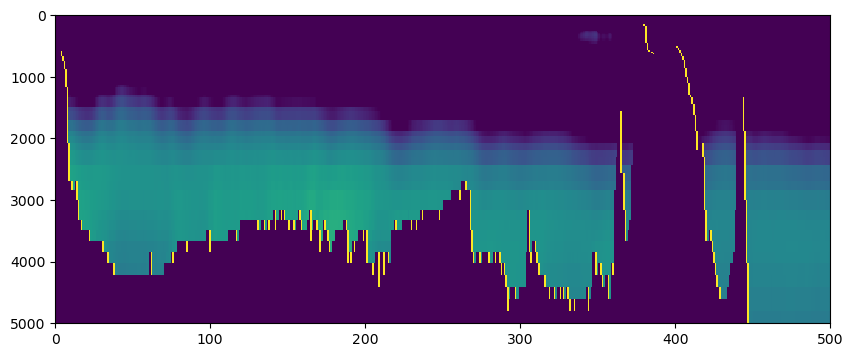

In [102]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.invert_yaxis()
ax.set_ylim(5000,0)
ax.set_xlim(0,500)
ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, ds.so.isel(y_grid_T=451), vmin=34.8, vmax=35)
# plot_land = np.ma.masked_where(mesh_mask.tmask.isel(y=451)==1, mesh_mask.tmask.isel(y=451))
# ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, plot_land, cmap=cmocean.cm.gray)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.invert_yaxis()g
ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, bdy_cond_new.SALT, vmin=33, vmax=36)
plot_land = np.ma.masked_where(mesh_mask.tmask.isel(y=451)==1, mesh_mask.tmask.isel(y=451))
ax.pcolormesh(np.arange(1,1441,1), domain_cfg.nav_lev, plot_land, cmap=cmocean.cm.gray)